In [2]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding,LSTM, CuDNNLSTM, Flatten, MaxPooling1D
from tensorflow.python.keras.layers import BatchNormalization, Dropout, TimeDistributed, Conv1D, Conv2D
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import h5py
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import shuffle
from time import time

import os
import sys

In [3]:
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from global_config import *

In [5]:
from s3fs.core import S3FileSystem
s3 = S3FileSystem()
from sagemaker import get_execution_role

role = get_execution_role()
bucket='files-and-examples-01'
train_file = 'datasets/su_dataset/video_data_low_level_A220.hdf5'

train_path = s3.open('s3://{}/{}'.format(bucket, train_file))

f = h5py.File(name=train_path, mode='r')
x = np.array(f['x'])
y = np.array(f['y'])

# Data selection and inspection

### Select anger and happiness

In [32]:
ang_idx = emotion_abr_to_emotion_id["ang"]
print("ang_idx:", ang_idx)
hap_idx = emotion_abr_to_emotion_id["hap"]
print("hap_idx:", hap_idx)

ang_idx: 12
hap_idx: 33


In [33]:
x_ang_hap = x[np.where((y == ang_idx) | (y == hap_idx))]
y_ang_hap = y[np.where((y == ang_idx) | (y == hap_idx))]

### Select Action Unit 4 number 2 (brow lowerer)

In [34]:
x_ang_hap_au04 = x_ang_hap[:, :, 2]

### Plot curves

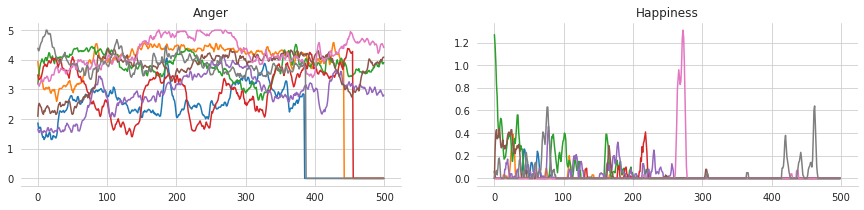

In [35]:
x_ang_au04 = x_ang_hap_au04[np.where(y_ang_hap == ang_idx)]
x_hap_au04 = x_ang_hap_au04[np.where(y_ang_hap == hap_idx)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
for vid_idx in range(8):
    axes[0].set_title("Anger")
    axes[1].set_title("Happiness")
    ts_ang = x_ang_au04[vid_idx, :500]
    ts_hap = x_hap_au04[vid_idx, :500]
    axes[0].plot(ts_ang)
    axes[1].plot(ts_hap)
plt.show()

# Scale the data (skipped for now)

### Inspect averages

In [36]:
print(x_ang_hap_au04.shape)
x_ang_hap_au04

(16, 1084)


array([[1.87, 1.69, 1.69, ..., 0.  , 0.  , 0.  ],
       [3.94, 3.7 , 3.51, ..., 0.  , 0.  , 0.  ],
       [3.18, 3.43, 3.62, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.26, 0.4 , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.05, 0.05, ..., 0.  , 0.  , 0.  ]], dtype=float32)

In [37]:
# gives the range of values for every row, e.g. video (there are 16 rows/videos)
np.ptp(x_ang_hap_au04, axis=1)

array([4.06, 4.58, 4.52, 4.38, 4.12, 4.42, 5.  , 5.  , 0.26, 0.39, 1.27,
       0.41, 0.46, 0.44, 1.31, 0.67], dtype=float32)

In [38]:
# inspect the average range of values
tot_avg = np.average(np.ptp(x_ang_hap_au04, axis=1))
print("total avg:", tot_avg)

ang_avg = np.average(np.ptp(x_ang_hap_au04[np.where(y_ang_hap == ang_idx)], axis=1))
print("anger avg:", ang_avg)

hap_avg = np.average(np.ptp(x_ang_hap_au04[np.where(y_ang_hap == hap_idx)], axis=1))
print("happiness avg:", hap_avg)

total avg: 2.580625
anger avg: 4.51
happiness avg: 0.65125


### Scale (skip for now)

Note: looking at the data after scaling it is evident that the padded values (zeros) will be scaled along with the rest of the time series, this might corrupt the data, so skip scaling for now

In [39]:
#scaler = MinMaxScaler(feature_range=(-2, 2))
#scaler = StandardScaler()
#x_ang_hap_au04 = scaler.fit_transform(x_ang_hap_au04)

In [40]:
# inspect the average range of values
tot_avg = np.average(np.ptp(x_ang_hap_au04, axis=1))
print("total avg:", tot_avg)

ang_avg = np.average(np.ptp(x_ang_hap_au04[np.where(y_ang_hap == ang_idx)], axis=1))
print("anger avg:", ang_avg)

hap_avg = np.average(np.ptp(x_ang_hap_au04[np.where(y_ang_hap == hap_idx)], axis=1))
print("happiness avg:", hap_avg)

total avg: 2.580625
anger avg: 4.51
happiness avg: 0.65125


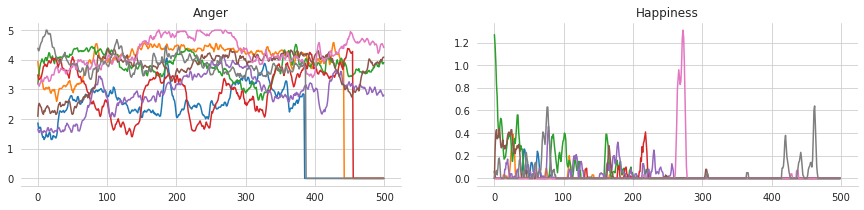

In [41]:
x_ang = x_ang_hap_au04[np.where(y_ang_hap == ang_idx)]
x_hap = x_ang_hap_au04[np.where(y_ang_hap == hap_idx)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
for vid_idx in range(8):
    axes[0].set_title("Anger")
    axes[1].set_title("Happiness")
    ts_ang = x_ang[vid_idx, :500]
    ts_hap = x_hap[vid_idx, :500]
    axes[0].plot(ts_ang)
    axes[1].plot(ts_hap)
plt.show()

# Ready data for training/testing

### Transform labels to binary

In [42]:
y_ang_hap[y_ang_hap == ang_idx] = 0
y_ang_hap[y_ang_hap == hap_idx] = 1

In [43]:
X_train, X_test, y_train, y_test = train_test_split(x_ang_hap_au04, y_ang_hap, test_size = 0.3, random_state=42)

### Reshape

In [44]:
print(X_train.shape)
X_test.shape

(11, 1084)


(5, 1084)

In [45]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [46]:
print(X_train.shape)
X_test.shape

(11, 1084, 1)


(5, 1084, 1)

# Build the model

In [75]:
seq_len=1084
STEPS = 50
EPOCHS= 60

NAME = f"td_suDB-{seq_len}seq_{int(time())}"
model_d = Sequential()


# model_d.add(BatchNormalization(input_shape=(seq_len,1)))
model_d.add(LSTM(units=100,
              return_sequences=True,
              input_shape=(seq_len,1)))

# model_d.add(Dropout(0.5))
# model_d.add(TimeDistributed(Dense(100, activation='relu')))

model_d.add(Flatten())
# model_d.add(Dropout(0.5))
model_d.add(Dense(100, activation='relu'))
# model_d.add(Dense(100, activation='relu'))

# model_d.add(Dropout(0.5))
model_d.add(Dense(1, activation='sigmoid'))


model_d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_d.summary()

Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-10-06 14:43:00.130 tensorflow-2-6-cpu-py-ml-t3-medium-71ce97b4283591d9dda4349036a8:93 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-10-06 14:43:00.246 tensorflow-2-6-cpu-py-ml-t3-medium-71ce97b4283591d9dda4349036a8:93 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1084, 100)         40800     
_________________________________________________________________
flatten (Flatten)         

In [78]:
model_d.fit(X_train, y_train, batch_size=500, epochs=EPOCHS, validation_data=(X_test, y_test))

Epoch 1/60
1/1 [==============================] - 36s 36s/step - loss: 7.2683e-08 - accuracy: 1.0000 - val_loss: 2.3053e-09 - val_accuracy: 1.0000
Epoch 2/60
1/1 [==============================] - 3s 3s/step - loss: 9.7628e-10 - accuracy: 1.0000 - val_loss: 2.6353e-11 - val_accuracy: 1.0000
Epoch 3/60
1/1 [==============================] - 3s 3s/step - loss: 9.9377e-12 - accuracy: 1.0000 - val_loss: 2.4993e-13 - val_accuracy: 1.0000
Epoch 4/60
1/1 [==============================] - 3s 3s/step - loss: 8.0772e-14 - accuracy: 1.0000 - val_loss: 4.4254e-14 - val_accuracy: 1.0000
Epoch 5/60
1/1 [==============================] - 3s 3s/step - loss: 5.5006e-16 - accuracy: 1.0000 - val_loss: 2.0921e-13 - val_accuracy: 1.0000
Epoch 6/60
1/1 [==============================] - 3s 3s/step - loss: 3.3291e-18 - accuracy: 1.0000 - val_loss: 1.2285e-12 - val_accuracy: 1.0000
Epoch 7/60
1/1 [==============================] - 3s 3s/step - loss: 2.2960e-19 - accuracy: 1.0000 - val_loss: 8.2931e-12 - val_

KeyboardInterrupt: 

# Running on all Action Units

In [49]:
x_ang_hap.shape

(16, 1084, 17)

In [50]:
y_ang_hap.shape

(16,)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(x_ang_hap, y_ang_hap, test_size = 0.3, random_state=42)

### Build the model 

In [56]:
seq_len=1084
STEPS = 50
EPOCHS= 60

NAME = f"td_suDB_all_action_units-{seq_len}seq_{int(time())}"
model_c = Sequential()


# model_d.add(BatchNormalization(input_shape=(seq_len,1)))
model_c.add(LSTM(units=100,
              return_sequences=True,
              input_shape=(seq_len,17)))

# model_d.add(Dropout(0.5))
# model_d.add(TimeDistributed(Dense(100, activation='relu')))

model_c.add(Flatten())
# model_d.add(Dropout(0.5))
model_c.add(Dense(100, activation='relu'))
# model_d.add(Dense(100, activation='relu'))

# model_d.add(Dropout(0.5))
model_c.add(Dense(1, activation='sigmoid'))


model_c.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_c.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1084, 100)         47200     
_________________________________________________________________
flatten_1 (Flatten)          (None, 108400)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10840100  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 10,887,401
Trainable params: 10,887,401
Non-trainable params: 0
_________________________________________________________________


In [57]:
model_c.fit(X_train, y_train, batch_size=500, epochs=EPOCHS, validation_data=(X_test, y_test))

Epoch 1/60
1/1 [==============================] - 7s 7s/step - loss: 0.6589 - accuracy: 0.6364 - val_loss: 2.3456e-05 - val_accuracy: 1.0000
Epoch 2/60
1/1 [==============================] - 3s 3s/step - loss: 3.2566e-05 - accuracy: 1.0000 - val_loss: 2.8162e-08 - val_accuracy: 1.0000
Epoch 3/60
1/1 [==============================] - 3s 3s/step - loss: 1.5326e-07 - accuracy: 1.0000 - val_loss: 1.0825e-10 - val_accuracy: 1.0000
Epoch 4/60
1/1 [==============================] - 4s 4s/step - loss: 2.2659e-09 - accuracy: 1.0000 - val_loss: 8.8219e-13 - val_accuracy: 1.0000
Epoch 5/60
1/1 [==============================] - 5s 5s/step - loss: 6.6754e-11 - accuracy: 1.0000 - val_loss: 1.2743e-14 - val_accuracy: 1.0000
Epoch 6/60


KeyboardInterrupt: 

# Running on more emotions

### Data selection

In [60]:
ang_idx = emotion_abr_to_emotion_id["ang"]
print("ang_idx:", ang_idx)
hap_idx = emotion_abr_to_emotion_id["hap"]
print("hap_idx:", hap_idx)
sad_idx = emotion_abr_to_emotion_id["sad"]
print("sad:", sad_idx)
disg_idx = emotion_abr_to_emotion_id["disg"]
print("disg:", disg_idx)
fea_idx = emotion_abr_to_emotion_id["fea"]
print("fea:", fea_idx)

ang_idx: 12
hap_idx: 33
sad: 6
disg: 35
fea: 10


In [62]:
x_basic_emotions = x[np.where((y == ang_idx) | (y == hap_idx) | (y == sad_idx) | (y == disg_idx) | (y == fea_idx))]
y_basic_emotions = y[np.where((y == ang_idx) | (y == hap_idx) | (y == sad_idx) | (y == disg_idx) | (y == fea_idx))]

In [69]:
y_basic_emotions[y_basic_emotions == ang_idx] = 0
y_basic_emotions[y_basic_emotions == hap_idx] = 1
y_basic_emotions[y_basic_emotions == sad_idx] = 2
y_basic_emotions[y_basic_emotions == disg_idx] = 3
y_basic_emotions[y_basic_emotions == fea_idx] = 4

In [64]:
x_basic_emotions.shape

(40, 1084, 17)

In [70]:
y_basic_emotions

array([0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2])

In [71]:
X_train, X_test, y_train, y_test = train_test_split(x_basic_emotions, y_basic_emotions, test_size = 0.3, random_state=42)

In [72]:
X_train.shape

(28, 1084, 17)

In [91]:
seq_len=1084
STEPS = 50
EPOCHS= 60

NAME = f"td_suDB_all_action_units_basic_emotions-{seq_len}seq_{int(time())}"
model_b = Sequential()


model_b.add(LSTM(units=100,
              return_sequences=True,
              input_shape=(seq_len,17)))

model_b.add(Flatten())
model_b.add(Dense(100, activation='relu'))

model_b.add(Dense(5, activation='sigmoid'))


model_b.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
model_b.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 1084, 100)         47200     
_________________________________________________________________
flatten_11 (Flatten)         (None, 108400)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10840100  
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 505       
Total params: 10,887,805
Trainable params: 10,887,805
Non-trainable params: 0
_________________________________________________________________


In [92]:
model_b.fit(X_train, y_train, batch_size=500, epochs=EPOCHS, validation_data=(X_test, y_test))

Epoch 1/60
1/1 [==============================] - 44s 44s/step - loss: 1.5898 - accuracy: 0.2500 - val_loss: 5.4203 - val_accuracy: 0.6667
Epoch 2/60
1/1 [==============================] - 4s 4s/step - loss: 2.4535 - accuracy: 0.5714 - val_loss: 4.8831 - val_accuracy: 0.5000
Epoch 3/60
1/1 [==============================] - 4s 4s/step - loss: 4.2175 - accuracy: 0.4643 - val_loss: 2.6933 - val_accuracy: 0.5833
Epoch 4/60
1/1 [==============================] - 4s 4s/step - loss: 1.9214 - accuracy: 0.6429 - val_loss: 1.7859 - val_accuracy: 0.6667
Epoch 5/60
1/1 [==============================] - 4s 4s/step - loss: 0.5993 - accuracy: 0.7500 - val_loss: 2.6383 - val_accuracy: 0.6667
Epoch 6/60
1/1 [==============================] - 4s 4s/step - loss: 0.4251 - accuracy: 0.8929 - val_loss: 2.8565 - val_accuracy: 0.7500
Epoch 7/60
1/1 [==============================] - 4s 4s/step - loss: 0.5111 - accuracy: 0.8929 - val_loss: 2.7079 - val_accuracy: 0.8333
Epoch 8/60
1/1 [=======================

KeyboardInterrupt: 

# Running on all emotions

In [6]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=42)

In [7]:
len(np.unique(y))

44

In [11]:
seq_len=1084
STEPS = 50
EPOCHS= 60

NAME = f"td_suDB_all-{seq_len}seq_{int(time())}"
model_a = Sequential()


model_a.add(LSTM(units=100,
              return_sequences=True,
              input_shape=(seq_len,17)))

model_a.add(Flatten())
model_a.add(Dense(100, activation='relu'))

model_a.add(Dense(44, activation='sigmoid'))


model_a.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1084, 100)         47200     
_________________________________________________________________
flatten_1 (Flatten)          (None, 108400)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10840100  
_________________________________________________________________
dense_3 (Dense)              (None, 44)                4444      
Total params: 10,891,744
Trainable params: 10,891,744
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_a.fit(X_train, y_train, batch_size=500, epochs=EPOCHS, validation_data=(X_test, y_test))

Epoch 1/60


Got memory error, will need to wait for allocation of more resources from AWS